# Motor City Eatery: Predicting the Best Locations for a New Restaurant in the City of Detroit

### Applied Data Science Capstone by IBM/Coursera

## Table of Contents

- [Introduction](#introduction)
- [Data](#data)
- [Methodology](#methodology) 
- [Analysis](#analysis)
- [Results and Discussion](#results) 
- [Conclusions](#conclusions)  

## Introduction <a name="introduction"></a>

Due to the low price of real estate and cost of living, many aspiring chefs have left places like New York City to open up their own restaurants in Detroit. This has resulted in an influx of young talent and Detroit has begun to be recognized as a great food city.  However, restaurants are still seen as a risky business venture no matter the city. Therefore, being able to use available data to aid in where to open a new restaurant could mitigate some of this risk. 

While someone may want to open or invest a new restaurant, factors such as crime or the presence and types of other restaurants for a given area may affect success of the new establishment.  Therefore, purpose of this project is to use these data to predict the best locations to open a new restaurant in Detroit. 

Potential investors and restauranteurs would be interested in learning where to open a new establishment. Using publicly available data will aid in reducing the risk in opening a new restaurant while potentially maximizing potential returns as Detroit continues to recover.

## Data <a name="data"></a>

There is a multitude of data available from the __city of Detroit__ via the city’s open data portal (https://data.detroitmi.gov). Datasets regarding crime from December 2016 through present available, which will be useful in determining the overall safety of an area. Sales of property through the 1970’s also exist as a dataset with almost a million transactions recorded. This could be useful in determining areas that would be affordable to buy a property, though we will limit analysis of this through December 2016 to match the crime dataset. __Foursquare__ also has a robust and large dataset that can be used to find the number and types of restaurants that already exist in an area. The analysis will seem to maximize areas that have some restaurant presence but not an oversaturated area.   

## Methodology <a name="methodology"></a>

Start by loading Detroit neighborhood data into a dataframe. 

In [1]:
import pandas as pd 
neighborhoods = pd.read_csv('Detroit_Neighborhoods.csv')
neighborhoods.head()

,the_geom,Join_Count,TARGET_FID,OBJECTID_1,OBJECTID,NHood_Name,NHood_Num,Shape_Leng,New_Nhood_,Acres,DistrictNu,Neighborho,Shape_Le_1,Shape_Area
0,MULTIPOLYGON (((-82.9915246858219 42.384389530...,3,1,1,1,Gratiot Woods,75,27277.074314,West End,1086.498842,4,103,31380.730047,3.171033e+07
1,MULTIPOLYGON (((-82.97584899959158 42.38933199...,1,2,2,2,Chandler Park,25,18822.431920,Chandler Park,496.783595,4,105,18822.431920,2.163981e+07
2,MULTIPOLYGON (((-82.96784188332737 42.38369428...,1,3,3,3,Fox Creek,60,30500.933274,Riverbend,1159.775632,4,100,22537.847022,3.118871e+07
3,MULTIPOLYGON (((-82.95140600040769 42.35502799...,2,4,4,4,Jefferson Chalmers,97,25466.579569,Jefferson Chalmers,901.711919,4,101,25466.579569,3.927841e+07
4,MULTIPOLYGON (((-83.25748031955806 42.41459686...,1,9,9,9,Riverdale,162,24864.047192,Riverdale,525.060549,1,29,16111.081891,1.409004e+07


Unfortunately, the dataset from the city doesn't have a latitude/longitude component, but we do have the name of each neighborhood. Let's use the new neighborhood name going forward since we can assume that's what it's called now. 

In [2]:
neighborhoods.shape

(208, 14)

We can see that there are __208__ neighborhood names. Let's see if we can clean up the data a little bit before we go any further. Let's start by just taking the name and acrage of the hood. 

In [3]:
neighborhood_names = pd.DataFrame(columns=['New_Nhood_','Acres'])
neighborhood_names['Hood'] = neighborhoods['New_Nhood_']
neighborhood_names['Acres'] = neighborhoods['Acres']

Using the Arcgis geocoder, we can try to find each hood within Detroit and get a latitude/longitude. 

In [4]:
import geocoder
latitude = []
longitude =[]

for hoods in neighborhood_names['Hood']:
    location = geocoder.arcgis(hoods+" Neighborhood, Detroit,MI")
    location.latlng
    
    # loop until you get the coordinates
    latitude.append(location.latlng[0])
    longitude.append(location.latlng[1])
    
neighborhood_names['Latitude'] = latitude
neighborhood_names['Longitude'] = longitude
neighborhood_names.head()

West End Detroit,MI
Chandler Park Detroit,MI
Riverbend Detroit,MI
Jefferson Chalmers Detroit,MI
Riverdale Detroit,MI
Morningside Detroit,MI
Cornerstone Village Detroit,MI
Regent Park Detroit,MI
North Rosedale Park Detroit,MI
Berg-Lahser Detroit,MI
Five Points Detroit,MI
The Eye Detroit,MI
Old Redford Detroit,MI
Grandmont Detroit,MI
Grandmont #1 Detroit,MI
Rosedale Park Detroit,MI
Minock Park Detroit,MI
Westwood Park Detroit,MI
Warrendale Detroit,MI
Garden View Detroit,MI
Warren Ave Community Detroit,MI
Far West Detroit Detroit,MI
Marina District Detroit,MI
Arden Park Detroit,MI
Joseph Berry Sub Detroit,MI
Indian Village Detroit,MI
Rivertown Detroit,MI
West Village Detroit,MI
Conner Creek Industrial Detroit,MI
Belmont Detroit,MI
Corktown Detroit,MI
Boynton Detroit,MI
Oakwood Heights Detroit,MI
Blackstone Park Detroit,MI
Delray Detroit,MI
Claytown Detroit,MI
Aviation Sub Detroit,MI
Barton-McFarland Detroit,MI
Medical Center Detroit,MI
Bagley Detroit,MI
Green Acres Detroit,MI
State Fair D

,New_Nhood_,Acres,Hood,Latitude,Longitude
0,NaN,1086.498842,West End,42.331680,-83.048000
1,NaN,496.783595,Chandler Park,42.396550,-82.969810
2,NaN,1159.775632,Riverbend,42.342357,-82.980571
3,NaN,901.711919,Jefferson Chalmers,42.365340,-82.945240
4,NaN,525.060549,Riverdale,42.410330,-83.265830


In [5]:
neighborhood_names.describe()

,Acres,Latitude,Longitude
count,208.000000,208.000000,208.000000
mean,440.723619,42.332674,-83.303577
std,399.761804,0.501718,2.418737
min,26.492368,35.488835,-111.930492
25%,170.278880,42.331680,-83.170637
50%,306.489939,42.359285,-83.061800
75%,614.328649,42.405853,-83.048000
max,3026.947549,42.985260,-70.933360


Now that we have the lat/long for each neighboorhood, we can visualize on a map. 

In [68]:
# create map
import folium # map rendering library
detroit_hoods = folium.Map(location=[42.3314, -83.0458], zoom_start=11)
import numpy as np
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
# set color scheme for the clusters
#x = np.arange(kclusters)
#ys = [i + x + (i*x)**2 for i in range(kclusters)]
#colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
#rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, acre in zip(neighborhood_names['Latitude'], neighborhood_names['Longitude'], neighborhood_names['Hood'], neighborhood_names['Acres']):
    label = folium.Popup(str(poi) + ', Size: ' + str(acre), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        #color=rainbow[cluster-1],
        fill=True,
        #fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(detroit_hoods)
       
detroit_hoods

Well that looks nifty! 

After some visual inspection of the map, we can see that it's likely that some of the neighborhoods weren't found like we'd expected and might have resulted in a duplicate point. So let's continue by removing those points. 

In [74]:
new_neighborhood_names = neighborhood_names.drop_duplicates(subset=['Latitude','Longitude'],keep='first')
new_neighborhood_names.shape

(138, 5)

Ok, so we have __138__ neighborhoods to work with. That's still plenty enough to cluster. So let's continue by finding the optimal number of clusters to work with by using the elbow test (examining the sum of square distances). 

## Analysis <a name="analysis"></a>

In [28]:
Sum_of_squared_distances = []
neighborhoods_clustering = new_neighborhood_names.drop(['New_Nhood_','Acres','Hood'],1)
K = range(1,21)
# import k-means from clustering stage
from sklearn.cluster import KMeans
#import pyplot
import matplotlib.pyplot as plt

for k in K:
    # run k-means clustering
    kmeans = KMeans(n_clusters=k, random_state=0).fit(neighborhoods_clustering)
    Sum_of_squared_distances.append(kmeans.inertia_) 



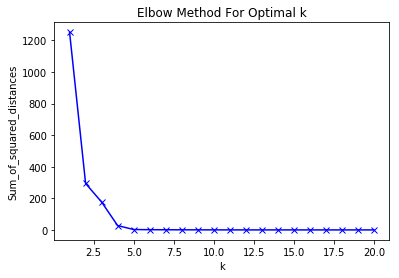

In [29]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

Looks like our optimal cluster number is 5. So we can continue looking at this with a cluster size of 5 and then visualize everything. 

In [66]:
kclusters = 5

# run k-means clustering
kmeans5 = KMeans(n_clusters=kclusters, random_state=0).fit(neighborhoods_clustering)
# check cluster labels generated for each row in the dataframe
kmeans5.labels_[0:10] 
new_neighborhood_names = new_neighborhood_names.drop(['Cluster_Labels'],1)
new_neighborhood_names.insert(0, 'Cluster_Labels', kmeans5.labels_)

In [69]:
# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, acre, cluster in zip(new_neighborhood_names['Latitude'], new_neighborhood_names['Longitude'], new_neighborhood_names['Hood'], new_neighborhood_names['Acres'], new_neighborhood_names['Cluster_Labels']):
    label = folium.Popup(str(poi) + ', Size: ' + str(acre)+', Cluster: '+str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(detroit_hoods)
       
detroit_hoods

Hmm that doesn't seem right. Let's zoom out a bit and see if there are any weird points outside the city. 

In [70]:
detroit_hoods2 = folium.Map(location=[42.3314, -83.0458], zoom_start=7)
for lat, lon, poi, acre, cluster in zip(new_neighborhood_names['Latitude'], new_neighborhood_names['Longitude'], new_neighborhood_names['Hood'], new_neighborhood_names['Acres'], new_neighborhood_names['Cluster_Labels']):
    label = folium.Popup(str(poi) + ', Size: ' + str(acre)+', Cluster: '+str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(detroit_hoods2)
       
detroit_hoods2

Well that explains it. It looks like the geocoder didn't work as well as we'd like. So let get rid of those points that are clearly outside the city limits and try to do KMeans again. We have 138 neighborhoods, so we can remove these and still have a good representation of Detroit's neighborhoods.

From manually inspecting the map, the points that need to get dropped are: 
- Waterworks Park
- Schaefer 7/8 Lodge
- Northeast Central District
- Douglass 
- Grant
- Piety Hill
- Rivertown
- Eden Gardens
- Southfield Plymouth

In [75]:
new_neighborhood_names = new_neighborhood_names.set_index("Hood")
new_neighborhood_names = new_neighborhood_names.drop(["Waterworks Park","Schaefer 7/8 Lodge","Northeast Central District","Douglass","Grant","Piety Hill","Rivertown","Eden Gardens","Southfield Plymouth"])
new_neighborhood_names.shape

(129, 4)

Let's repeat the KMeans test again, but this time with only 129 hoods that are _actually_ in Detroit. 

In [77]:
Sum_of_squared_distances = []
neighborhoods_clustering = new_neighborhood_names.drop(['New_Nhood_','Acres'],1)
K = range(1,21)
# import k-means from clustering stage
from sklearn.cluster import KMeans
#import pyplot
import matplotlib.pyplot as plt

for k in K:
    # run k-means clustering
    kmeans = KMeans(n_clusters=k, random_state=0).fit(neighborhoods_clustering)
    Sum_of_squared_distances.append(kmeans.inertia_) 

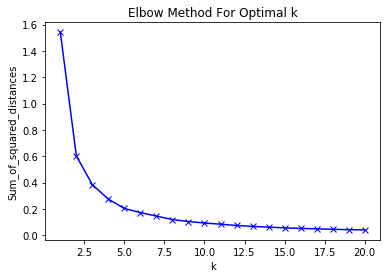

In [78]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

Using the elbow test again, we can see that ~15 is probably the right size cluster. So let's repeat all we did before with KMeans where the cluster size is __15__. 

In [80]:
kclusters = 15

# run k-means clustering
kmeans5 = KMeans(n_clusters=kclusters, random_state=0).fit(neighborhoods_clustering)
# check cluster labels generated for each row in the dataframe
kmeans5.labels_[0:10] 
#new_neighborhood_names = new_neighborhood_names.drop(['Cluster_Labels'],1)
new_neighborhood_names.insert(0, 'Cluster_Labels', kmeans5.labels_)

In [82]:
# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, cluster in zip(new_neighborhood_names['Latitude'], new_neighborhood_names['Longitude'], new_neighborhood_names['Cluster_Labels']):
    label = folium.Popup('Cluster: '+str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(detroit_hoods)
       
detroit_hoods

That's more like it! Ok, so let's check the size of each cluster.  

In [84]:
new_neighborhood_names['Cluster_Labels'].value_counts()

1     17
8     12
5     12
4     12
7     11
10     9
14     7
13     7
9      7
0      7
6      6
3      6
2      6
12     5
11     5
Name: Cluster_Labels, dtype: int64

Each cluster has at least 5 in it so let's get the center of the centroids for each neighborhood and save them to a new dataframe.

In [113]:
hood_clusters = pd.DataFrame(kmeans5.cluster_centers_,columns=['Lat','Lon'])
#kmeans5.labels_
hood_clusters

,Lat,Lon
0,42.419454,-83.231023
1,42.344902,-83.045628
2,42.440001,-82.977042
3,42.375067,-83.141000
4,42.429973,-83.141462
5,42.367863,-83.239070
6,42.277712,-83.154569
7,42.361056,-82.981332
8,42.365287,-83.084392
9,42.397591,-83.009826


And then map the centroid of each cluster. 

In [114]:
Clusternames = []
for label in range(0,len(hood_clusters)):
    Clusternames.append('Cluster'+str(label))
#hood_clusters['ClusterName'] = Clusternames
#hood_clusters

In [85]:
markers_colors = []
detroit_hoods2 = folium.Map(location=[42.3314, -83.0458], zoom_start=11)
for lat, lon, cluster in zip(hood_clusters['Lat'], hood_clusters['Lon'], hood_clusters.index):
    label = folium.Popup('Cluster: '+str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(detroit_hoods2)
       
detroit_hoods2

Next, let's take a look at crime in near each of our neighborhood candidates. To do this, we will use the Detroit Police Department incident log available from the City. This dataset is all crime in the city since December 16, 2017. 

Let's begin by loading this into a Dataframe. 

In [277]:
crimes_csv = pd.read_csv('DPD__All_Crime_Incidents__December_6__2016_-_Present.csv')
crimes_csv = crimes_csv.dropna(subset=['Longitude','Latitude'])
crimes_csv['Incident Date & Time'] = pd.to_datetime(crimes_csv['Incident Date & Time'])
crimes_csv.head()

,Crime ID,Report #,Incident Address,Offense Description,Offense Category,Charge Description,Offense Code,State Offense Code,Incident Date & Time,Incident Time (24h),...,Latitude,IBR Report Date,Location,uniq,Hardest Hit Fund Areas,City Council Districts,Detroit Neighborhoods,Scout Car Areas,Counties,Zip Codes
0,3349940,1904250137,18700 block of STAHELIN AVE,ASSAULT AND BATTERY/SIMPLE ASSAULT,ASSAULT,ASSAULT AND BATTERY/SIMPLE ASSAULT,13001,1301,2019-04-25 10:30:00,1030,...,42.427625,04/25/2019 01:04:06 PM,"location\n(42.42763, -83.22759)",35872,2.0,1.0,186.0,56.0,1345.0,19613.0
1,3349940,1904250137,18700 block of STAHELIN AVE,ASSAULT AND BATTERY/SIMPLE ASSAULT,DAMAGE TO PROPERTY,DAMAGE TO PROPERTY,29000,2900,2019-04-25 10:30:00,1030,...,42.427625,04/25/2019 01:04:06 PM,"location\n(42.42763, -83.22759)",154902,2.0,1.0,186.0,56.0,1345.0,19613.0
2,3349891,1904250096,6400 block of BRACE ST,DAMAGE TO PROPERTY,DAMAGE TO PROPERTY,DAMAGE TO PROPERTY,29000,2900,2019-04-25 09:03:00,903,...,42.337099,04/25/2019 01:04:06 PM,"location\n(42.3371, -83.22304)",154898,10.0,7.0,21.0,129.0,1345.0,20016.0
3,3349887,1904250103,11100 block of GRATIOT AVE,LARCENY - OTHER,LARCENY,LARCENY - OTHER,23007,2307,2019-04-25 09:00:00,900,...,42.408272,04/25/2019 01:04:06 PM,"location\n(42.40827, -82.99535)",100718,NaN,4.0,171.0,70.0,1345.0,19202.0
4,3349886,1904250106,18600 block of FORRER ST,FRAUD - IMPERSONATION,FRAUD,FRAUD - IMPERSONATION,26003,2603,2019-04-25 08:30:00,830,...,42.426724,04/25/2019 01:04:06 PM,"location\n(42.42672, -83.20245)",131077,2.0,2.0,118.0,57.0,1345.0,20021.0


The only information we are concerned with are the Latitude, Longitude, and Date of each incident. Let's save a new dataframe with just this information. 

In [283]:
crimes_loc = crimes_csv[['Latitude','Longitude','Incident Date & Time']]
crimes_loc.head()

,Latitude,Longitude,Incident Date & Time
0,42.427625,-83.227585,2019-04-25 10:30:00
1,42.427625,-83.227585,2019-04-25 10:30:00
2,42.337099,-83.223037,2019-04-25 09:03:00
3,42.408272,-82.995355,2019-04-25 09:00:00
4,42.426724,-83.202452,2019-04-25 08:30:00


Let's see how many crimes have happened in the past year and change. 

In [284]:
crimes_loc.shape

(195277, 3)

_Yowza..._ that's a lot of crime. Perhaps if we look at the incidence for each month and find out if there's a month that would be the most representive to limit the amount of data we have to look at. 

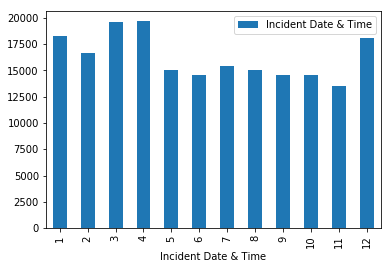

In [307]:
crime_date= crimes_csv[["Incident Date & Time"]]
crime_date.groupby(crime_date["Incident Date & Time"].dt.month).count().plot(kind="bar")

It looks pretty consisent across each month, so let's limit it to the past month since April seems as good of a month to examine. 

In [285]:
from datetime import datetime, timedelta
yearago = datetime.now()-timedelta(days=30)
crimes_loc = crimes_loc.loc[crimes_csv['Incident Date & Time'] > yearago, ['Latitude', 'Longitude','Incident Date & Time']]
crimes_loc.shape

(2280, 3)

We still have a sizable amount of incidents to examine, with 2280 incidents in the past month. 

Let's create an empty dataframe and calculate the number of incidents within a half mile radius of each cluster. 

In [346]:
#crimes_dist = pd.concat([crimes_loc,pd.DataFrame(columns=Clusternames)],sort=False)
index = range(0,crimes_loc.shape[0]+5)
crimes_dist = pd.DataFrame(columns=Clusternames,index=index)

crimes_dist.head()

,Cluster0,Cluster1,Cluster2,Cluster3,Cluster4,Cluster5,Cluster6,Cluster7,Cluster8,Cluster9,Cluster10,Cluster11,Cluster12,Cluster13,Cluster14
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [347]:
import geopy.distance
for i in hood_clusters.itertuples():
    for j in crimes_loc.itertuples():
        hood_coord = (i.Lat,i.Lon)
        crime_coord = (j.Latitude,j.Longitude)
        vicinity = geopy.distance.distance(hood_coord, crime_coord).mi
        crimes_dist.iloc[j.Index,i.Index] = vicinity

In [348]:
crimes_dist.head()

,Cluster0,Cluster1,Cluster2,Cluster3,Cluster4,Cluster5,Cluster6,Cluster7,Cluster8,Cluster9,Cluster10,Cluster11,Cluster12,Cluster13,Cluster14
0,0.590738,10.9218,12.8387,5.72535,4.40679,4.16656,11.0018,13.4105,8.49594,11.329,2.94511,15.3677,8.82309,3.09599,10.0092
1,0.590738,10.9218,12.8387,5.72535,4.40679,4.16656,11.0018,13.4105,8.49594,11.329,2.94511,15.3677,8.82309,3.09599,10.0092
2,5.69906,9.10021,14.4524,4.95028,7.64963,2.27656,5.39497,12.485,7.36002,11.6844,6.47607,15.8845,10.8518,4.08974,6.38287
3,12.0782,5.07451,2.38185,7.79633,7.62087,12.7783,12.1519,3.33703,5.43679,1.04481,14.7861,3.4372,3.51109,10.1046,8.32775
4,1.54484,9.81261,11.5617,4.75348,3.12673,4.47382,10.5732,12.1872,7.37997,10.0555,4.2051,14.0818,7.54289,2.48947,9.18058


In [359]:
cluster_crime = crimes_dist[crimes_dist < 1].count()
cluster_crime

Cluster0      50
Cluster1      73
Cluster2      43
Cluster3      42
Cluster4     747
Cluster5      55
Cluster6       7
Cluster7      23
Cluster8      35
Cluster9      16
Cluster10     28
Cluster11     36
Cluster12     48
Cluster13     45
Cluster14     26
dtype: int64

Now we have the number of crime incidents within half a mile of each cluster. Lets add it to our old dataframe and organize by incidents. 

In [366]:
hood_clusters['Crime_Past_Month'] = cluster_crime.values
hood_candidates = hood_clusters.sort_values(by=['Crime_Past_Month'])
hood_candidates

,Lat,Lon,Crime_Past_Month
6,42.277712,-83.154569,7
9,42.397591,-83.009826,16
7,42.361056,-82.981332,23
14,42.316804,-83.101450,26
10,42.419292,-83.284067,28
8,42.365287,-83.084392,35
11,42.408907,-82.928162,36
3,42.375067,-83.141000,42
2,42.440001,-82.977042,43
13,42.391567,-83.191584,45


It looks like we have a couple of clear delineations and that we can take our top 5 neighborhoods as the finalists. Let's remap them and see where each of them are. 

In [371]:
hood_candidates = hood_candidates.head()
hood_candidates.head()

,Lat,Lon,Crime_Past_Month
6,42.277712,-83.154569,7
9,42.397591,-83.009826,16
7,42.361056,-82.981332,23
14,42.316804,-83.101450,26
10,42.419292,-83.284067,28


In [373]:
markers_colors = []
detroit_hoods3 = folium.Map(location=[42.3314, -83.0458], zoom_start=11)
for lat, lon, cluster, crime in zip(hood_candidates['Lat'], hood_candidates['Lon'], hood_candidates.index, hood_candidates['Crime_Past_Month']):
    label = folium.Popup('Cluster: '+str(cluster)+', Crime Incidents: '+str(crime), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(detroit_hoods3)
       
detroit_hoods3

Our client would like the new restaurant to be as close to downtown as possible, so let's go ahead and eliminate Cluster 10 and Cluster 6. This leaves us with Clusters 7, 9, and 14. These areas correspond roughly with the areas of _Southwest Detroit (14), Southeast Detroit (7), and Northeast Detroit (9)_. 

So now that we have our neighborhood candidates narrowed to 3, we can take an in-depth look at each neighborhood and what kind of restaurants exist in the remaining areas. To do this, we will utilize the Foursquare API. 

In [443]:
import requests
CLIENT_ID = 'TMW4KKAGVOIU4OWXSMN1SRNR43AC24CLNSLOCIBGJGPEDAVH' # your Foursquare ID
CLIENT_SECRET = '5MYUMGAC455SMVM2PEXIYQGO1N00R4OSUPCYXWSIRGSKNCUM' # your Foursquare Secret
VERSION = '20180604'
LIMIT = 30
search_query = 'Restaurant'
radius = 1600

Query each candidate's latitude and longitude and find out how many restaurants are within a mile radius. 

In [458]:
Candidate1 = hood_candidates.loc[14]
latitude = Candidate1.Lat
longitude = Candidate1.Lon
url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, search_query, radius, LIMIT)
results1 = requests.get(url).json()

In [459]:
Candidate2 = hood_candidates.loc[7]
latitude = Candidate2.Lat
longitude = Candidate2.Lon
url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, search_query, radius, LIMIT)
results2 = requests.get(url).json()

In [460]:
Candidate3 = hood_candidates.loc[9]
latitude = Candidate3.Lat
longitude = Candidate3.Lon
url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, search_query, radius, LIMIT)
results3 = requests.get(url).json()

Now let's do some reoganization and get each of the resulting JSON files into dataframes. 

In [461]:
from pandas.io.json import json_normalize

# assign relevant part of JSON to venues
venues1 = results1['response']['venues']
venues2 = results2['response']['venues']
venues3 = results3['response']['venues']

# tranform venues into a dataframe
dataframe1 = json_normalize(venues1)
dataframe2 = json_normalize(venues2)
dataframe3 = json_normalize(venues3)

# keep only columns that include venue name, and anything that is associated with location
filtered_columns1 = ['name', 'categories'] + [col for col in dataframe1.columns if col.startswith('location.')] + ['id']
dataframe_filtered1 = dataframe1.loc[:, filtered_columns1]
filtered_columns2 = ['name', 'categories'] + [col for col in dataframe2.columns if col.startswith('location.')] + ['id']
dataframe_filtered2 = dataframe2.loc[:, filtered_columns2]
filtered_columns3 = ['name', 'categories'] + [col for col in dataframe3.columns if col.startswith('location.')] + ['id']
dataframe_filtered3 = dataframe3.loc[:, filtered_columns3]

# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

# filter the category for each row
dataframe_filtered1['categories'] = dataframe_filtered1.apply(get_category_type, axis=1)
dataframe_filtered2['categories'] = dataframe_filtered2.apply(get_category_type, axis=1)
dataframe_filtered3['categories'] = dataframe_filtered3.apply(get_category_type, axis=1)

# clean column names by keeping only last term
dataframe_filtered1.columns = [column.split('.')[-1] for column in dataframe_filtered1.columns]
dataframe_filtered2.columns = [column.split('.')[-1] for column in dataframe_filtered2.columns]
dataframe_filtered3.columns = [column.split('.')[-1] for column in dataframe_filtered3.columns]


In [462]:
dataframe_filtered1

,name,categories,address,cc,city,country,crossStreet,distance,formattedAddress,labeledLatLngs,lat,lng,postalCode,state,id
0,Colombo's Coney Island Restaurant,American Restaurant,5414 W Vernor Hwy,US,Detroit,United States,Near Junction St,169,"[5414 W Vernor Hwy (Near Junction St), Detroit...","[{'label': 'display', 'lat': 42.31830122599812...",42.318301,-83.101103,48209,MI,4bf7c8248d30d13a307fff17
1,Xochimilco Restaurant,Mexican Restaurant,3409 Bagley St,US,Detroit,United States,at 23rd St,1541,"[3409 Bagley St (at 23rd St), Detroit, MI 4821...","[{'label': 'display', 'lat': 42.32330830210945...",42.323308,-83.084919,48216,MI,4ad111bdf964a52073dc20e3
2,Mexican Town Restaurant,Mexican Restaurant,3457 Bagley St,US,Detroit,United States,btw. Fisher Fwy. and Grand Blvd.,1458,[3457 Bagley St (btw. Fisher Fwy. and Grand Bl...,"[{'label': 'display', 'lat': 42.322908589417, ...",42.322909,-83.085766,48216,MI,4a46bd39f964a5205fa91fe3
3,Hygrade Restaurant & Deli,Deli / Bodega,3640 Michigan Ave,US,Detroit,United States,NaN,1758,"[3640 Michigan Ave, Detroit, MI 48216, United ...","[{'label': 'display', 'lat': 42.33162759737287...",42.331628,-83.094073,48216,MI,4ad8cc67f964a520c11421e3
4,Ho Ho Village Restaurant,Chinese Restaurant,5821 W Vernor Hwy,US,Detroit,United States,NaN,221,"[5821 W Vernor Hwy, Detroit, MI 48209, United ...","[{'label': 'display', 'lat': 42.31669856575067...",42.316699,-83.104137,48209,MI,4eaef75a82319d82629d5aad
5,Amigo Lebanese Restaurant,Food,1644 Lansing St,US,Detroit,United States,NaN,230,"[1644 Lansing St, Detroit, MI 48209, United St...","[{'label': 'display', 'lat': 42.316815, 'lng':...",42.316815,-83.104253,48209,MI,4f44a89219836ed001959dcb
6,Taqueria & Restaurant Los Corrales,Mexican Restaurant,2244 Junction,US,Detroit,United States,Toledo,491,"[2244 Junction (Toledo), Detroit, MI 48209, Un...","[{'label': 'display', 'lat': 42.32086196663572...",42.320862,-83.103813,48209,MI,4be19dc958102d7fff064256
7,Patagonia Restaurant Parrilladas,Argentinian Restaurant,4314 W Vernor Hwy,US,Detroit,United States,NaN,667,"[4314 W Vernor Hwy, Detroit, MI 48209, United ...","[{'label': 'display', 'lat': 42.32062872453677...",42.320629,-83.095211,48209,MI,51054a4b805551d2458ca4b9
8,Popocatel Mexican town Restaurant,Mexican Restaurant,NaN,US,Detroit,United States,NaN,1350,"[Detroit, MI, United States]","[{'label': 'display', 'lat': 42.32222, 'lng': ...",42.322220,-83.086770,NaN,MI,56929bf3498e90ef2ce3306f
9,Benjis Restaurant,Mexican Restaurant,3149 Livernois Ave,US,Detroit,United States,NaN,1459,"[3149 Livernois Ave, Detroit, MI 48210, United...","[{'label': 'display', 'lat': 42.324662, 'lng':...",42.324662,-83.115652,48210,MI,4e4e48b4bd4101d0d7a6d0b7


It seems there are 13 restaurants and are mostly mexican restaurants in the Southwest cluster.

In [478]:
dataframe_filtered2

,name,categories,address,cc,city,country,crossStreet,distance,formattedAddress,labeledLatLngs,lat,lng,postalCode,state,id
0,Sindbad's Restaurant & Marina,Seafood Restaurant,100 Saint Clair St,US,Detroit,United States,at Freud St.,731,"[100 Saint Clair St (at Freud St.), Detroit, M...","[{'label': 'display', 'lat': 42.35764224839727...",42.357642,-82.973727,48214,MI,4bae7ffaf964a520e2b93be3
1,Indian Restaurant,Indian Restaurant,NaN,US,Detroit,United States,NaN,1652,"[Detroit, MI 48214, United States]","[{'label': 'display', 'lat': 42.36209260418282...",42.362093,-83.001376,48214,MI,50c069f3e4b092606c44faa5
2,Detroit Yacht Club,Harbor / Marina,1 Riverbank Rd,US,Detroit,United States,Belle Isle,1481,"[1 Riverbank Rd (Belle Isle), Detroit, MI 4820...","[{'label': 'display', 'lat': 42.34889555015027...",42.348896,-82.974002,48207,MI,4be577c22457a593bd7aab15


There are 3 restaurants in the Southeast cluster. 

In [464]:
dataframe_filtered3

,name,categories,address,cc,city,country,distance,formattedAddress,labeledLatLngs,lat,lng,postalCode,state,id
0,Hong Moy,Chinese Restaurant,7415 Harper Ave,US,Detroit,United States,1750,"[7415 Harper Ave, Detroit, MI 48213, United St...","[{'label': 'display', 'lat': 42.38658964633942...",42.38659,-83.025033,48213,MI,4e6af0c1e4cdb37551ceb9d3


And finally, there is only 1 restaurant in the Northeast cluster of Detroit. 

Let's compile all the restaurants into one dataframe and then plot them all onto a map to visualize. 

In [471]:
compiled_df = pd.concat([dataframe_filtered1,dataframe_filtered2,dataframe_filtered3],sort=False)
compiled_df

,name,categories,address,cc,city,country,crossStreet,distance,formattedAddress,labeledLatLngs,lat,lng,postalCode,state,id
0,Colombo's Coney Island Restaurant,American Restaurant,5414 W Vernor Hwy,US,Detroit,United States,Near Junction St,169,"[5414 W Vernor Hwy (Near Junction St), Detroit...","[{'label': 'display', 'lat': 42.31830122599812...",42.318301,-83.101103,48209,MI,4bf7c8248d30d13a307fff17
1,Xochimilco Restaurant,Mexican Restaurant,3409 Bagley St,US,Detroit,United States,at 23rd St,1541,"[3409 Bagley St (at 23rd St), Detroit, MI 4821...","[{'label': 'display', 'lat': 42.32330830210945...",42.323308,-83.084919,48216,MI,4ad111bdf964a52073dc20e3
2,Mexican Town Restaurant,Mexican Restaurant,3457 Bagley St,US,Detroit,United States,btw. Fisher Fwy. and Grand Blvd.,1458,[3457 Bagley St (btw. Fisher Fwy. and Grand Bl...,"[{'label': 'display', 'lat': 42.322908589417, ...",42.322909,-83.085766,48216,MI,4a46bd39f964a5205fa91fe3
3,Hygrade Restaurant & Deli,Deli / Bodega,3640 Michigan Ave,US,Detroit,United States,NaN,1758,"[3640 Michigan Ave, Detroit, MI 48216, United ...","[{'label': 'display', 'lat': 42.33162759737287...",42.331628,-83.094073,48216,MI,4ad8cc67f964a520c11421e3
4,Ho Ho Village Restaurant,Chinese Restaurant,5821 W Vernor Hwy,US,Detroit,United States,NaN,221,"[5821 W Vernor Hwy, Detroit, MI 48209, United ...","[{'label': 'display', 'lat': 42.31669856575067...",42.316699,-83.104137,48209,MI,4eaef75a82319d82629d5aad
5,Amigo Lebanese Restaurant,Food,1644 Lansing St,US,Detroit,United States,NaN,230,"[1644 Lansing St, Detroit, MI 48209, United St...","[{'label': 'display', 'lat': 42.316815, 'lng':...",42.316815,-83.104253,48209,MI,4f44a89219836ed001959dcb
6,Taqueria & Restaurant Los Corrales,Mexican Restaurant,2244 Junction,US,Detroit,United States,Toledo,491,"[2244 Junction (Toledo), Detroit, MI 48209, Un...","[{'label': 'display', 'lat': 42.32086196663572...",42.320862,-83.103813,48209,MI,4be19dc958102d7fff064256
7,Patagonia Restaurant Parrilladas,Argentinian Restaurant,4314 W Vernor Hwy,US,Detroit,United States,NaN,667,"[4314 W Vernor Hwy, Detroit, MI 48209, United ...","[{'label': 'display', 'lat': 42.32062872453677...",42.320629,-83.095211,48209,MI,51054a4b805551d2458ca4b9
8,Popocatel Mexican town Restaurant,Mexican Restaurant,NaN,US,Detroit,United States,NaN,1350,"[Detroit, MI, United States]","[{'label': 'display', 'lat': 42.32222, 'lng': ...",42.322220,-83.086770,NaN,MI,56929bf3498e90ef2ce3306f
9,Benjis Restaurant,Mexican Restaurant,3149 Livernois Ave,US,Detroit,United States,NaN,1459,"[3149 Livernois Ave, Detroit, MI 48210, United...","[{'label': 'display', 'lat': 42.324662, 'lng':...",42.324662,-83.115652,48210,MI,4e4e48b4bd4101d0d7a6d0b7


In [477]:
# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(len(compiled_df))]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]
markers_colors = []

detroit_hoods4 = folium.Map(location=[42.3314, -83.0458], zoom_start=11)
for lat, lon, name, index in zip(compiled_df['lat'], compiled_df['lng'], compiled_df['name'], compiled_df.index):
    label = folium.Popup(str(name), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[index-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(detroit_hoods4)
       
detroit_hoods4

## Results and Discussion <a name="results"></a>

Our analysis shows that there are 3 high potential neighborhood clusters in the City of Detroit to develop a new restaurant. We started with 200 unique neighborhoods and clustered them into 15 unique areas. The clusters were spread all over the city and led us to look at other factors to narrow the search. The city of Detroit's crime dataset is a convenient way to quickly assess the safety of a given cluster. Analyzing the crime for each cluster allowed us to reduce the number of candidate neighborhoods from 15 to 5. Using geography, we were able to remove another 2 clusters from analysis, leaving us with 3 candidate areas: Southwest, Northeast, and Southeast. Each cluster has its pros and cons. 

The Northeast cluster is not close to the downtown core. It also only has one restaurant near its core. While it has the lowest incidence of crime, this may be indicative of lack of any development when paired with the restaurant density. It would not be recommended as an option based on the data. 

The Southwest cluster is in close proximity to the downtown area. It also has a network of existing restaurants in the area, which could indicate that it is a thriving area that could support more restaurants. Additionally, the types of restaurants it has are mostly Mexican, meaning that other developments could be successful and stand out in this area. It also is close to new developments in the area like the Ford rehabilitation of the Michigan Central Station and will likely be a thriving area very soon. Crime is also relatively low. The number of restaurants in the area could also be seen as a negative, as there would be more competition, especially if the desired restaurant type is Mexican. 

The Southeast cluster geographically is situated on the other side of downtown, opposite of the Southwest cluster. There are currently not many restaurants in this area, so it could be ripe for development. Perhaps the best characteristic is close to Belle Isle, which thrives during when it is not winter, as it is Michigan's most popular state park with approximately 4 million people visiting annually. It also is the site of the Detroit Grand Prix every spring. Crime-wise is about equal as the Southwest cluster. It also includes neighhoods such as Indian village that are healthy neighborhoods and proximal to the affluent suburb of Grosse Pointe. 

## Conclusions <a name="conclusions"></a>

The purpose of this investigation was to find locations that might be ripe for development of new restaurants to aid potential investors and/or restauranteuers in selecting a site to open their new establishment. By clustering neighborhoods together, we were able to do find similar neighborhoods and allow us to narrow our search. We then used indexed each neighborhood cluster by incidence of crime to narrow our search to 5 candidate neighborhoods. Because of the desire of our investors to be close to the downtown core, this elimiated two addiational clusters, leaving us with 3 candidate neighborhood clusters. The final determination of where to open the new restaurant will be left up to the stakeholders based on other factors such as microneighborhood factors, availability and affordability of real estate, other developments in the area, promity to downtown, and areas of interest that will drive traffic to the restaurant. That said, there seem to be few downsides to the Southeast cluster and would be our recommendation for a new restaurant. However future developments near the Southwest cluster make it intriguing in the future. 